# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

**Автор:** Арамян Элен

**Дата:** 08.03.2025

**Цель:** Провести исследовательский анализ данных рынка заведений общественного питания Москвы и выявить определенные закономерности и рекомендации, полезные для инвесторов при открытии заведния.

**Задачи:**
- Загрузить данные и познакомиться с ними
- Предобработать данные и нормализовать их.
- Провести исследовательский анализ данных и продемонстрировать резульататы с помощью наглядной визуализации.
- Выявить закономерности, подвести итоги и сформулировать рекомендации.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
#Импортируем библиотеки 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.stats.power import NormalIndPower
from math import ceil
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

In [2]:
#Cохраним в датафрейм `sessions_history` CSV-файл с историческими данными
sessions_history = pd.read_csv('/datasets/sessions_project_history.csv')

#Выведем первые строки
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными ок
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`. 

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них. 

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [3]:
# Рассчитаем кол-во уникальный сессий для каждого пользователя
sessions_history.groupby('user_id').agg({'session_id':'nunique'}).sort_values(by='session_id', ascending=False)

,session_id
user_id,
10E0DEFC1ABDBBE0,10
6A73CB5566BB494D,10
8A60431A825D035B,9
D11541BAC141FB94,9
5BCFE7C4DCC148E9,9
...,...
1DF13BB1953B3497,1
628502A3CE7E0A3C,1
1DEEF40DEFBD0C65,1


In [4]:
# Выведем пользователя с наибольшим количеством сессий
sessions_history[sessions_history['user_id']=='10E0DEFC1ABDBBE0']

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


За выбранный период макс кол-во сессий 10, причем пользователь без регистрации и проявлял активность в первые 11 дней после установки

#### 1.3. Анализ числа регистраций **ок**
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням. 

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

In [5]:
# число уникальных и зарегестрированных пользователейпользователей в разрезе дней
users = sessions_history.groupby('session_date').agg({'user_id':'nunique','registration_flag':'sum'})
users = users.reset_index()
users.columns = ['session_date', 'users_count', 'registrated_users_count']
display(users)

,session_date,users_count,registrated_users_count
0,2025-08-11,3919,169
1,2025-08-12,6056,336
2,2025-08-13,8489,464
3,2025-08-14,10321,625
4,2025-08-15,14065,840
5,2025-08-16,12205,916
6,2025-08-17,11200,833
7,2025-08-18,10839,860
8,2025-08-19,12118,831
9,2025-08-20,13514,1008


Text(0, 0.5, 'Количество пользователей')

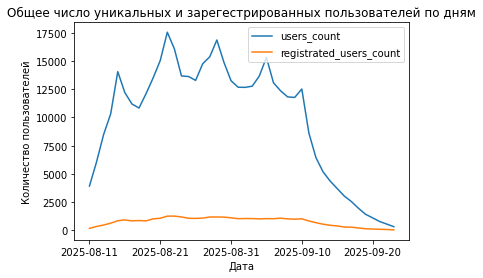

In [6]:
# Визуализируем данные

users.plot(kind='line', x='session_date', y=['users_count', 'registrated_users_count'])
plt.title('Общее число уникальных и зарегестрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')

Text(0, 0.5, 'Количество пользователей')

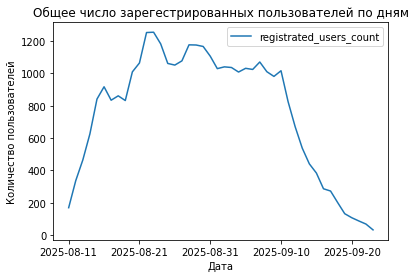

In [7]:
# Отображать оба показателя на одном графике не совсем корректно и может привести к ложным выводам из-за различий в масштабах
# поэтому выведем отдельно число зарег пользователей
users.plot(kind='line', x='session_date', y='registrated_users_count')
plt.title('Общее число зарегестрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')

Text(0, 0.5, 'Доля пользователей')

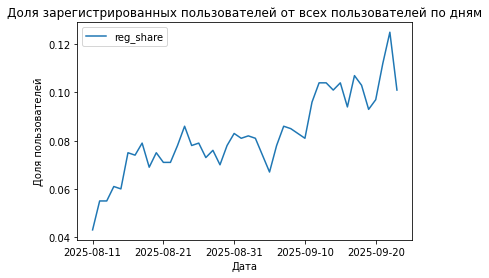

In [8]:
# Доля зарегистрированных пользователей от всех пользователей по дням
users['reg_share'] = round(users['registrated_users_count'] / users['users_count'],3)
users.plot(kind='line', x='session_date', y='reg_share')
plt.title('Доля зарегистрированных пользователей от всех пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Доля пользователей')

Из графиков видим следующее:
+ количество уникальных пользователей сильно колебалось изо дня в день, но после 10 сентября пошло на спад (возможно, это связано с тем, что у пользователей началась учеба/работа, из-за чего меньше свободного времени)
+ число зарегестрированных пользователей тоже сильно колебалось, однако после 10 сентября также прослеживается тенденция на снижение
+ доля зарегестрированных же пользователей, хоть и нестабильно, но показывает рост, даже после 10 сентября (это говорит о том, что покидают приложение в большей степени незарегестрированные пользователи)

#### 1.4. Анализ числа просмотренных страниц 
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее. 

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий. 

- На диаграмме должны быть заголовок, подписанные оси X и Y.

<AxesSubplot:title={'center':'Число просмотренных страниц в приложении'}, xlabel='Кол-во просмотренных страниц', ylabel='Кол-во сессий'>

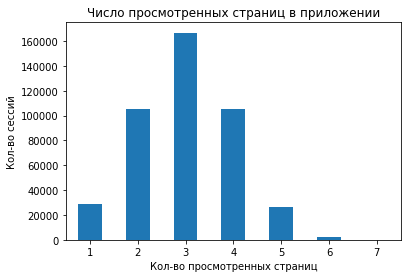

In [9]:
sessions_history.groupby('page_counter')['session_id'].count().plot(kind='bar',
                                                                    rot=0, 
                                                                    xlabel='Кол-во просмотренных страниц',
                                                                    ylabel='Кол-во сессий',
                                                                    title='Число просмотренных страниц в приложении') 

In [10]:
sessions_history.groupby('page_counter')['session_id'].count()

page_counter
1     29160
2    105536
3    166690
4    105569
5     26288
6      2589
7        92
Name: session_id, dtype: int64

Чаще всего пользователи просматривают 3 страницы, чуть меньше 2 и 4

#### 1.5. Доля пользователей, просмотревших более четырёх страниц 
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше. 

- Постройте график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения. 

In [11]:
# Cоздадим дополнительный столбец
sessions_history['good_session'] = np.where(sessions_history['page_counter'] >= 4, 1,0) 
display(sessions_history)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0
...,...,...,...,...,...,...,...,...,...,...,...
435919,769BC199AF26FEF8,914903B51D69C5EA,2025-09-17,2025-09-17 21:33:57,2025-09-04,3,1,3,CIS,PC,0
435920,599DED39F3CD2ADE,66ADBE343C94DCDA,2025-09-17,2025-09-17 17:11:46,2025-09-04,4,0,4,MENA,iPhone,1
435921,1FA20C4BC94E64B2,C4CCD7E81733665F,2025-09-17,2025-09-17 19:36:55,2025-09-04,4,0,4,CIS,Android,1
435922,88E5FC3016A7A0AD,6834FB4914B56200,2025-09-17,2025-09-17 22:13:33,2025-09-04,5,0,4,MENA,PC,1


In [12]:
# Добавим столбец со средним значением доли успешных сессий
success_sessions = sessions_history.groupby('session_date').agg({'session_id':'count', 'good_session':'sum'})
success_sessions = success_sessions.reset_index()
success_sessions.columns = ['session_date', 'session_count', 'good_session_count']
success_sessions['good_sessions_share'] = success_sessions['good_session_count'] / success_sessions['session_count'] 

# проверка
display(success_sessions)

,session_date,session_count,good_session_count,good_sessions_share
0,2025-08-11,3919,1226,0.312835
1,2025-08-12,6056,1829,0.302015
2,2025-08-13,8489,2604,0.306750
3,2025-08-14,10321,3262,0.316055
4,2025-08-15,14065,4289,0.304941
5,2025-08-16,12205,3737,0.306186
6,2025-08-17,11200,3557,0.317589
7,2025-08-18,10839,3366,0.310545
8,2025-08-19,12118,3791,0.312840
9,2025-08-20,13514,4148,0.306941


<AxesSubplot:title={'center':'Доля успешных сессий по дням'}, xlabel='Дата', ylabel='Доля'>

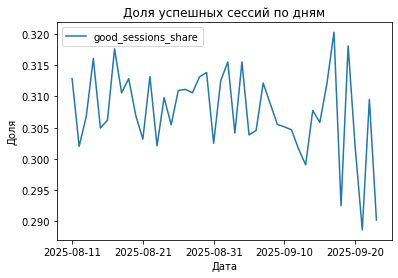

In [13]:
# Визуализируем
success_sessions.plot(kind='line', 
                      x='session_date',
                      y='good_sessions_share',                       
                      xlabel='Дата',
                      ylabel='Доля',
                      title='Доля успешных сессий по дням')

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки ок
В рамках курса вам уже приходилось рассчитывать размеры выборки, используя онлайн-калькуляторы. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего дизайна эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [14]:
# Задаём параметры
alpha = 0.05   # Уровень значимости
beta = 0.2   # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
mde = 0.03   # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста ок

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [15]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = ceil(sessions_history.groupby('session_date')['user_id'].nunique().mean())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2  / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9908 пользователей в день составит 4 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей **ок**

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения. 

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой можно было бы увидеть возможное различие двух групп. 

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [16]:
sessions_test_part = pd.read_csv('/datasets/sessions_project_test_part.csv')
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [17]:
# количество уникальных пользователей в каждой из экспериментальных групп 
sessions_test_part.groupby('test_group')['user_id'].nunique()

test_group
A    1477
B    1466
Name: user_id, dtype: int64

In [18]:
# процентная разница в группах А и В
A = 1477
B = 1466

groups_diff = round((abs(A-B) / A ) * 100 ,2 )
print(groups_diff)

0.74


<AxesSubplot:title={'center':'Количество пользователей в группах'}, ylabel='user_id'>

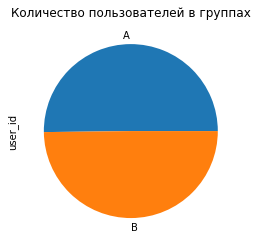

In [19]:
# Визуализируем
sessions_test_part.groupby('test_group')['user_id'].nunique().plot(kind='pie',
                                                                  title='Количество пользователей в группах'
                                                                  )

Разница незначительная - менее 1%, значит пользователи разделены корректно 

#### 3.2. Проверка пересечений пользователей 
Помимо проверки равенства количества пользователей в группах полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [20]:
# выведем уникальные айди для групп
gr_a = sessions_test_part[sessions_test_part['test_group']=='A'].groupby('test_group')['user_id'].unique()
gr_b = sessions_test_part[sessions_test_part['test_group']=='B'].groupby('test_group')['user_id'].unique()

# ищем совпадения одинаковых айди
common = list(set(gr_a.iloc[0]) & set(gr_b.iloc[0]))
print(common)

[]


Совпадений в столбце user_id нет, а значит группы независимы

#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


In [21]:
devices_a = sessions_test_part[sessions_test_part['test_group']=='A'].groupby('device')['user_id'].nunique()
sum_devices_a = devices_a.sum()
a_devices_share = round(devices_a / sum_devices_a,2)
print(a_devices_share)

device
Android    0.44
Mac        0.11
PC         0.25
iPhone     0.20
Name: user_id, dtype: float64


<AxesSubplot:title={'center':'Доля устройств для группы А'}, ylabel='user_id'>

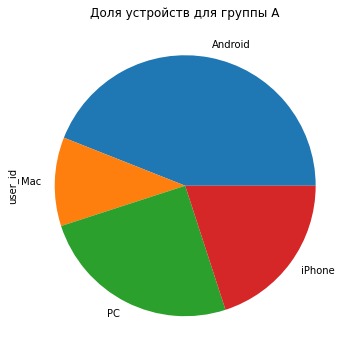

In [22]:
# Визаулизируем
a_devices_share.plot(kind='pie', 
                     figsize=(8, 6),
                     title='Доля устройств для группы А')

In [23]:
devices_b = sessions_test_part[sessions_test_part['test_group']=='B'].groupby('device')['user_id'].nunique()
sum_devices_b = devices_b.sum()
b_devices_share = round(devices_b / sum_devices_b,2)
print(b_devices_share)

device
Android    0.46
Mac        0.10
PC         0.26
iPhone     0.18
Name: user_id, dtype: float64


<AxesSubplot:title={'center':'Доля устройств для группы В'}, ylabel='user_id'>

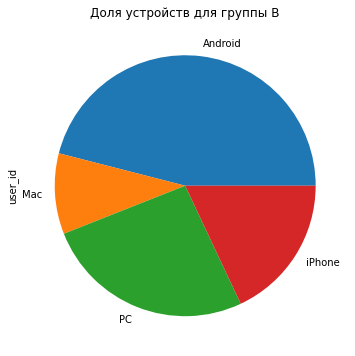

In [24]:
# Визаулизируем
b_devices_share.plot(kind='pie', 
                     figsize=(8, 6),
                     title='Доля устройств для группы В')

Видим, что доли типов устройств в двух группах примерно одинаковые (наибольшее кол-во устройств - андроид, далее ПК, айфоны и мак), значит пользователи распределены равномерно

**ВОПРОС:** как сделать 1 график, на котором будут 2 диаграммки? слева и справа

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


In [25]:
region_a = sessions_test_part[sessions_test_part['test_group']=='A'].groupby('region')['user_id'].nunique()
sum_region_a = region_a.sum()
a_region_share = round(region_a / sum_region_a,2)
print(a_region_share)

region
CIS     0.44
EU      0.15
MENA    0.41
Name: user_id, dtype: float64


<AxesSubplot:title={'center':'Доля каждого региона для группы А'}, xlabel='region', ylabel='Доля'>

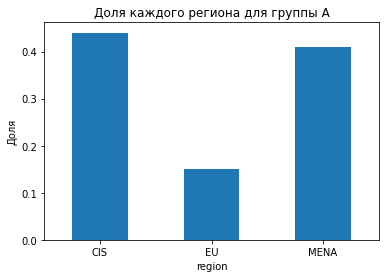

In [26]:
# Визуализируем
a_region_share.plot(kind='bar',
                   rot=0,
                   title="Доля каждого региона для группы А",
                   ylabel="Доля")

In [27]:
region_b = sessions_test_part[sessions_test_part['test_group']=='B'].groupby('region')['user_id'].nunique()
sum_region_b = region_b.sum()
b_region_share = round(region_b / sum_region_b,2)
print(b_region_share)

region
CIS     0.44
EU      0.15
MENA    0.41
Name: user_id, dtype: float64


<AxesSubplot:title={'center':'Доля каждого региона для группы В'}, xlabel='region', ylabel='Доля'>

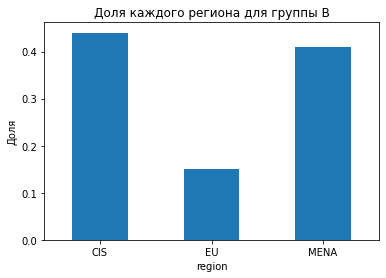

In [28]:
# Визуализируем
b_region_share.plot(kind='bar',
                   rot=0,
                   title="Доля каждого региона для группы В",
                   ylabel="Доля")

Видим, что доли регионов одинаковы, значит пользователи распределены равномерно

#### 3.5. Вывод после проверки A/B-теста 

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Были ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение о том, корректно ли проходит A/B-тест или наблюдаются какие-либо нарушения.

После проверки А/В-теста можно заключить, что
+ различий в количестве пользователей в двух группах не обнаружено
+ выборки независимы - пересечение пользователей отсутствует
+ относительно категориальных групп пользователи распределены равномерно, явных перекосов нет

Исходя из этого можно утверждать, что A/B-тест проходит корректно, все условия для правильного проведения эксперимента соблюдены

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики 
- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [29]:
sessions_test = pd.read_csv('/datasets/sessions_project_test.csv')

In [30]:
# Cоздадим дополнительный столбец
sessions_test['good_session'] = np.where(sessions_test['page_counter'] >= 4, 1,0) 
display(sessions_test)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...
100000,CF77C27B238C1BE3,0F7BC9B33685377C,2025-10-22,2025-10-22 19:01:50,2025-10-20,3,0,3,MENA,Android,A,0
100001,D7ED66C581409AC2,26C4475005E70F47,2025-10-17,2025-10-17 22:12:38,2025-10-17,1,0,5,CIS,PC,A,1
100002,E7EA2D51238020C6,9B9CDE6A612CBD73,2025-10-24,2025-10-24 14:54:07,2025-10-14,2,0,3,MENA,PC,B,0
100003,8A6FEFD7F34C5DA1,37291EC27106EF9D,2025-10-18,2025-10-18 00:05:10,2025-10-14,3,0,4,EU,Android,B,1


#### 4.2. Проверка корректности результатов теста 

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку. 

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок. 

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его. 

In [31]:
# Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп
tabl = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().reset_index()
display(tabl)

,session_date,test_group,session_id
0,2025-10-14,A,1502
1,2025-10-14,B,1628
2,2025-10-15,A,2235
3,2025-10-15,B,2283
4,2025-10-16,A,3280
5,2025-10-16,B,3241
6,2025-10-17,A,4089
7,2025-10-17,B,4054
8,2025-10-18,A,5013
9,2025-10-18,B,5059


In [32]:
# Проверим что количество уникальных дневных сессий в двух выборках не различается
group_a = tabl[tabl['test_group']=='A']['session_id']
group_b = tabl[tabl['test_group']=='B']['session_id']


alpha = 0.05

results = st.ttest_ind(
        group_a,
        group_b,
        alternative='two-sided')

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.938219304859116
Не получилось отвергнуть нулевую гипотезу


#### 4.3. Сравнение доли успешных сессий 

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [33]:
# Кол-во успешных сессий для выборки А
success_sessions_a = sessions_test[sessions_test['test_group']=='A']['good_session'].sum()
# Общее кол-во строк для выборки А
summary_sessions_a = sessions_test[sessions_test['test_group']=='A']['good_session'].count()
# Доля успешных сессий для выборки А
share_a = success_sessions_a / summary_sessions_a


# Кол-во успешных сессий для выборки B
success_sessions_b = sessions_test[sessions_test['test_group']=='B']['good_session'].sum()
# Общее кол-во строк для выборки В
summary_sessions_b = sessions_test[sessions_test['test_group']=='B']['good_session'].count()
# Доля успешных сессий для выборки В
share_b = success_sessions_b / summary_sessions_b

print('Доля успешных сессий для выборки А = ', round(share_a,2))
print('Доля успешных сессий для выборки B = ', round(share_b,2))
print('Разница между долями успешных сессий выборок А и В:', round(share_a- share_b,3))

Доля успешных сессий для выборки А =  0.31
Доля успешных сессий для выборки B =  0.32
Разница между долями успешных сессий выборок А и В: -0.011


#### 4.4. Насколько статистически значимо изменение ключевой метрики 

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым. 

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым. 

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05. 

В данном случае, когда мы сравниваем доли успешных сессий между двумя выборками, для определения статистической значимости изменения необходимо использовать Z-тест для пропорций

**Нулевая гипотеза:**
Различий между долями успешных сессий нет

**Альтернативная гипотеза:**
Доля успешных сессий в тестовой группе в группе А ниже, чем в группе В

ОДНАКО для использования данного теста нужно проверить несколько условий, часть из них мы проверили выше. Остается проверить,  выполняется ли предпосылка Z-теста пропорций о достаточном размере выборок:

In [34]:
# Проверим, достаточен ли размер выборок для Z-теста

# Рассчитаем кол-во успехов в группах (просто переименую их из кода выше для удобства)
m_a = success_sessions_a
m_b = success_sessions_b

# Рассчитаем размер групп
n_a = sessions_test[sessions_test['test_group']=='A'].shape[0]
n_b = sessions_test[sessions_test['test_group']=='B'].shape[0]

# Рассчитаем доли успехов (просто переименую их из кода выше для удобства)
p_a = share_a
p_b = share_b

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

Предпосылка о достаточном количестве данных выполняется!


In [35]:
alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller' 
)
p_value_ztest

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.0001574739988036123 < 0.05
Нулевая гипотеза не находит подтверждения!


**Получается, что изменение является статистически значимым. Нулевая гипотеза не находит подтверждения: доля успешных сессий в группе В действительно повысилась**

#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как. 

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять новоовведение в приложение. 

1) Создание нового алгоритма рекомендаций, который будет показывать более интересный контент для каждого пользователя. Для этого проведен эксперимент, в ходе которого было задействовано 1477 (в одной группе) + 1466 (в другой) = 2943 пользователя. Тест проводился с 14 октября по 2 ноября, т.е. 20 дней

2) Внедрение нового алгоритма рекомендаций повлияло на рост ключевой метрики: доля успешных сессий для тестовой группы действительно выше, чем для группы, у которой не было никаких изменений.Разница между долями составляет 1.1%

3) pvalue=0.000157, что меньше alpha = 0.05, а значит 1.1% - статистически значимое изменение, тк гипотеза о том, что внедрение нового алгоритма не повлияет на долю успешных сессий не находит подверждения.

4) Изменение, судя по результатам теста, принесет положительный результат, т.е. доля успешных сессий (сессий, где просмотрено более 4 страниц) станет больше, однако данные показывают незначительное изменение, которое выявилось на протяжении 20 дней эксперимента. Несмотря на то, что даже такое небольшое изменение может привести к росту дохода в долгосрочной перспективе (особенно с возможностью дальнейшей оптимизации алгоритма), но нужно рассматривать ситуацию более глобально: если затраты на внедрение велики, то увеличение дохожа может их не окупить. Более того, нужно убедиться, что нововведение не будет ухудшать другие метрики (и в целом не ухудшит работу приложения). Поэтому **ответ** - из-за незначительного прироста доли успешных сессий тест показывает НЕДОСТАТОЧНЫЙ результат для принятия решение, тк итог может быть неоднозначным, поэтому в идеале нужно учесть затраты, влияение на другие метрики и только после этого делать выбор.